In [1]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import json
from torchvision.transforms import transforms
import random
from sklearn.model_selection import train_test_split

In [5]:
from PIL import Image
import torch
import random

class FaceDataset_Triplet():
    def __init__(self, df, path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        # Initialize these attributes for both training and testing modes
        self.images = df.iloc[:, 0].values
        self.labels = df.iloc[:, 1].values
        self.index = df.index.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = f'{self.path}/{self.labels[item]}/{anchor_image_name}'
        anchor_img = Image.open(anchor_image_path).convert('RGB')

        positive_img = None
        negative_img = None
        anchor_label = self.labels[item]

        if self.is_train:
            positive_list = self.index[(self.index != item) & (self.labels == anchor_label)]
            positive_item = random.choice(positive_list)
            positive_image_name = self.images[positive_item]
            positive_image_path = f'{self.path}/{self.labels[positive_item]}/{positive_image_name}'
            positive_img = Image.open(positive_image_path).convert('RGB')

            negative_list = self.index[(self.index != item) & (self.labels != anchor_label)]
            negative_item = random.choice(negative_list)
            negative_image_name = self.images[negative_item]
            negative_image_path = f'{self.path}/{self.labels[negative_item]}/{negative_image_name}'
            negative_img = Image.open(negative_image_path).convert('RGB')

        if self.transform:
            anchor_img = self.transform(anchor_img)
            if self.is_train:
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label


In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
data = pd.read_csv('img_lbl.csv')
data_path = 'Dataset'

In [8]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
train_df.shape, test_df.shape

((1407, 2), (352, 2))

In [10]:
train_dataset = FaceDataset_Triplet(train_df, path=data_path, train=True, transform=train_transforms)
test_dataset = FaceDataset_Triplet(test_df, path=data_path, train=False, transform=test_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

## Training

In [12]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive -
                            distance_negative + self.margin)

        return losses.mean()

In [14]:
import torch.nn as nn
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingNet, self).__init__()

        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(base_model.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


In [15]:
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
print(f'Using device: {device}')

Using device: cuda


In [17]:
model = EmbeddingNet(embedding_dim=128).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = TripletLoss(margin=1.0).to(device)

for epoch in range(num_epochs):
    for data in train_loader:
      optimizer.zero_grad()
      # Unpack all items in the tuple and move each to the device
      anchor_img, positive_img, negative_img, _ = data
      anchor_img = anchor_img.to(device)
      positive_img = positive_img.to(device)
      negative_img = negative_img.to(device)

      anchor_emb = model(anchor_img)
      positive_emb = model(positive_img)
      negative_emb = model(negative_img)

      loss = loss_fn(anchor_emb, positive_emb, negative_emb)
      loss.backward()
      optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lea

Epoch 1, Loss: 0.8983283042907715
Epoch 2, Loss: 0.5122693777084351
Epoch 3, Loss: 0.5297166705131531
Epoch 4, Loss: 0.3219333291053772
Epoch 5, Loss: 0.7887963652610779
Epoch 6, Loss: 0.4718245267868042
Epoch 7, Loss: 0.8722084760665894
Epoch 8, Loss: 0.4790085554122925
Epoch 9, Loss: 0.6548277139663696
Epoch 10, Loss: 0.7625596523284912
Epoch 11, Loss: 0.5364543795585632
Epoch 12, Loss: 0.5517899394035339
Epoch 13, Loss: 0.5015347599983215
Epoch 14, Loss: 0.4353983998298645
Epoch 15, Loss: 0.5608944892883301
Epoch 16, Loss: 0.5239217281341553
Epoch 17, Loss: 0.48528537154197693
Epoch 18, Loss: 0.4218471944332123
Epoch 19, Loss: 0.775962233543396
Epoch 20, Loss: 0.23668785393238068
Epoch 21, Loss: 0.620287299156189
Epoch 22, Loss: 0.33358651399612427
Epoch 23, Loss: 0.5235059261322021
Epoch 24, Loss: 0.6657603979110718
Epoch 25, Loss: 0.2665243446826935
Epoch 26, Loss: 0.4365198016166687
Epoch 27, Loss: 0.4959307014942169
Epoch 28, Loss: 0.2615055441856384
Epoch 29, Loss: 0.5928219556

In [18]:
from sklearn.preprocessing import LabelEncoder

def get_embeddings_and_labels(data_loader, model, device):
    label_encoder = LabelEncoder()

    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for images, _, _, labels in data_loader:
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu().numpy())
            labels_list.append(labels)

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    labels = label_encoder.fit_transform(labels)

    return embeddings, labels


In [19]:
from sklearn.manifold import TSNE

def apply_tsne(flattened_images):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(flattened_images)

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import os

def scatter(x, labels, subtitle=None, dataset='FaceDataset'):
    num_classes = len(set(labels))  # Calculate the number of classes
    palette = np.array(sns.color_palette("hls", num_classes))  # Choosing color

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    idx2name = ['Bright Spring', 'Bright Winter', 'Cool Summer', 'Cool Winter', 'Deep Autumn', 'Deep Winter', 'Light Spring', 'Light Summer', 'Soft Autumn', 'Soft Summer', 'Warm Autumn', 'Warm Spring']
    txts = []
    for i in range(num_classes):
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, idx2name[i], fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    if subtitle is not None:
        plt.suptitle(subtitle)

    plt.show()

In [22]:
train_emb, train_lbl = get_embeddings_and_labels(train_loader, model, device)
#test_emb, test_lbl = get_embeddings_and_labels(test_loader, model, device)

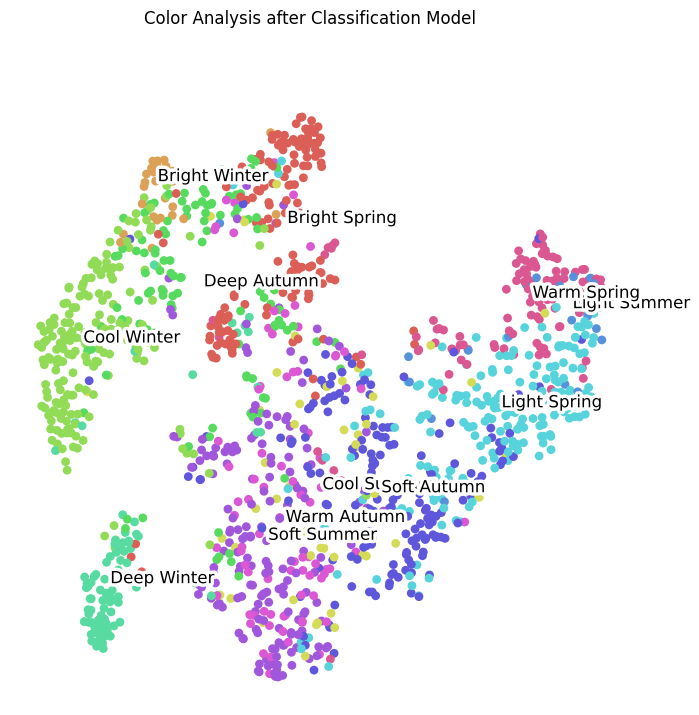

In [23]:
tsne_results = apply_tsne(train_emb)

scatter(tsne_results, train_lbl, subtitle='Color Analysis after Classification Model')

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_emb, train_lbl, test_size=0.2, random_state=42)



In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=30)

In [42]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of kNN classifier on test set: {accuracy * 100:.2f}%")


Accuracy of kNN classifier on test set: 73.05%


In [69]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, max_features='sqrt')

# Train the classifier
rf.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=4)

In [70]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest classifier on test set: {accuracy * 100:.2f}%")


Accuracy of Random Forest classifier on test set: 70.57%


In [74]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear', C=1)  # You can experiment with the kernel, e.g., 'rbf', 'poly'
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of SVM: {accuracy_svm * 100:.2f}%")


Accuracy of SVM: 71.28%


In [77]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=5)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy of XGBoost: {accuracy_xgb * 100:.2f}%")


Accuracy of XGBoost: 70.21%


In [78]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy of MLP Neural Network: {accuracy_mlp * 100:.2f}%")


Accuracy of MLP Neural Network: 74.47%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
